## Universidad del Valle de Guatemala
##### Integrantes
* Juan Manuel Marroquin Alfaro 19845
* Carlos Alberto Raxtúm Ramos 19721
* Jose Abraham Gutierrez Corado 19111
* Walter Danilo Saldaña Salguero 19897
* Javier Alejandro Cotto Argueta 19324

import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import seaborn as sns
import scipy.stats as stats
import seaborn as sn
from pandas_profiling import ProfileReport
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
train = pd.read_csv('./videos/train.csv',low_memory=False)
# convert Nan to empty list
train[['event_attributes']] = train[['event_attributes']].fillna('')

In [4]:
train.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,
3,1606b0e6_0,210.124111,start,
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


#### Pequena informacion de los datos antes de manipularlos

In [5]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,11218.0,1787.796418,860.84597,175.025822,1050.63525,1769.089449,2527.93275,3575.000727


In [6]:
train.describe(include=['O']).transpose()

,count,unique,top,freq
video_id,11218,12,1606b0e6_1,1249
event,11218,5,play,3586
event_attributes,11218,15,,6836


In [7]:
train['event'].unique()

array(['start', 'challenge', 'end', 'throwin', 'play'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='event'>

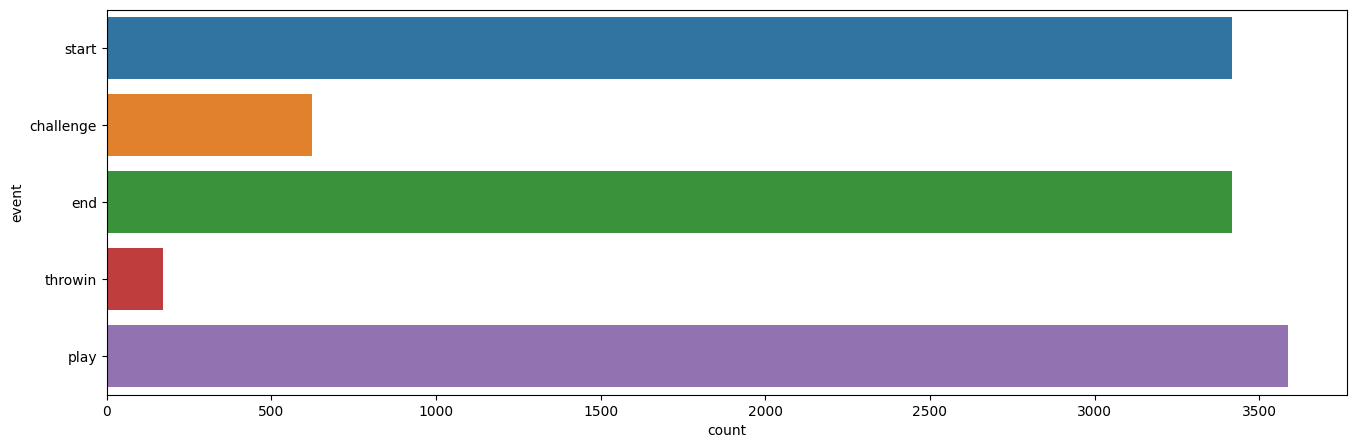

In [9]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, y="event")

In [26]:
train['event'].value_counts().sort_index()

challenge     624
end          3418
play         3586
start        3418
throwin       172
Name: event, dtype: int64

<AxesSubplot:xlabel='count', ylabel='video_id'>

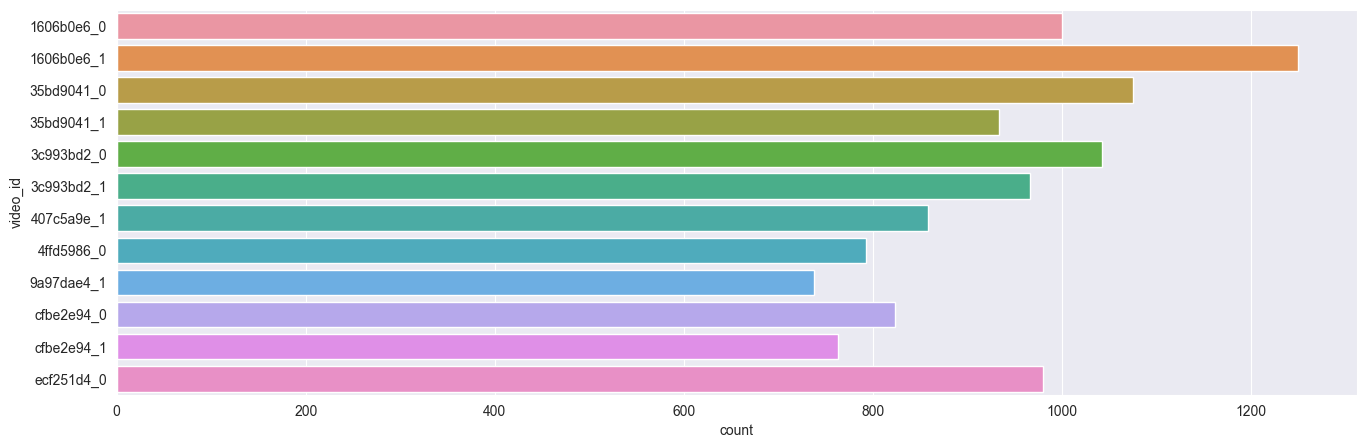

In [18]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, y="video_id")

In [25]:
train['video_id'].value_counts().sort_index()

1606b0e6_0    1000
1606b0e6_1    1249
35bd9041_0    1075
35bd9041_1     933
3c993bd2_0    1042
3c993bd2_1     966
407c5a9e_1     858
4ffd5986_0     792
9a97dae4_1     737
cfbe2e94_0     823
cfbe2e94_1     763
ecf251d4_0     980
Name: video_id, dtype: int64

<AxesSubplot:xlabel='count', ylabel='event_attributes'>

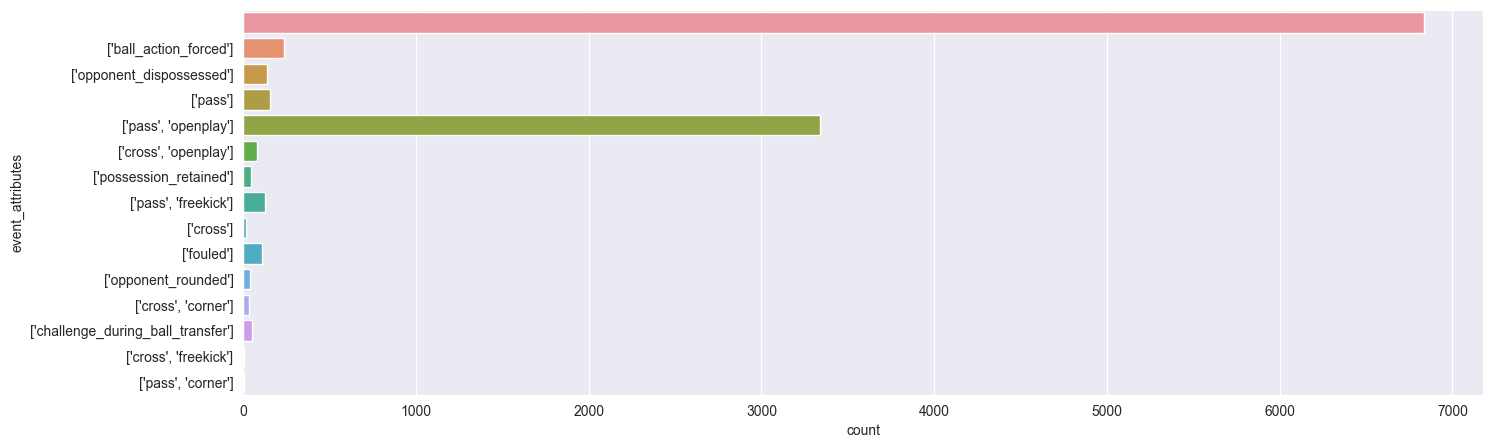

In [19]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, y="event_attributes")

In [27]:
train['event_attributes'].value_counts().sort_index()

                                      6836
['ball_action_forced']                 239
['challenge_during_ball_transfer']      53
['cross', 'corner']                     33
['cross', 'freekick']                    5
['cross', 'openplay']                   80
['cross']                               18
['fouled']                             111
['opponent_dispossessed']              138
['opponent_rounded']                    39
['pass', 'corner']                       4
['pass', 'freekick']                   127
['pass', 'openplay']                  3337
['pass']                               154
['possession_retained']                 44
Name: event_attributes, dtype: int64

<AxesSubplot:xlabel='count', ylabel='video_id'>

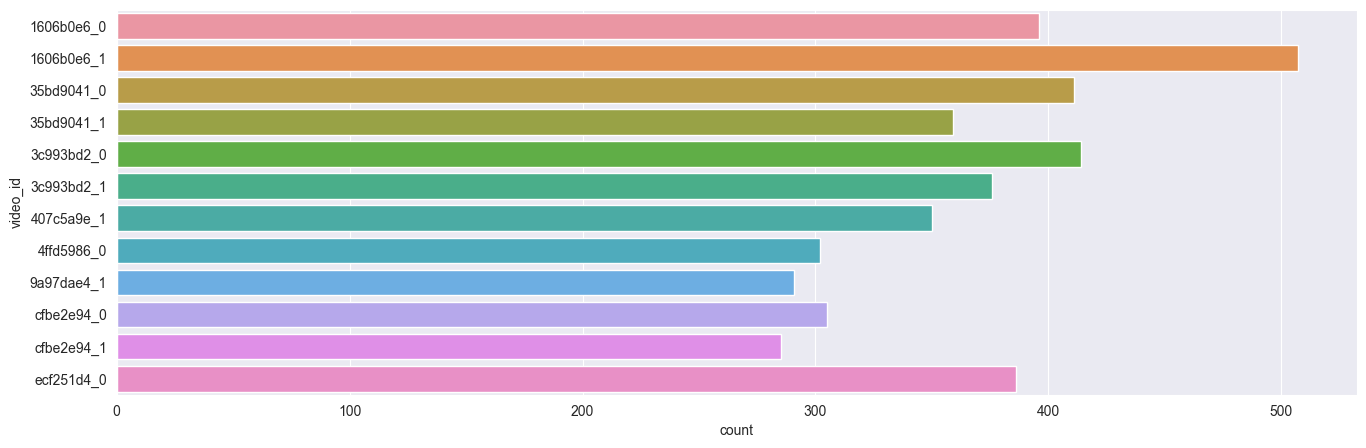

In [22]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train[(train["event"] != "start") & (train["event"] != "end")], y="video_id")

In [11]:
train.groupby('event')['event_attributes'].value_counts().to_frame().sort_index()

event_attributes
event     event_attributes                                    
challenge ['ball_action_forced']                           239
          ['challenge_during_ball_transfer']                53
          ['fouled']                                       111
          ['opponent_dispossessed']                        138
          ['opponent_rounded']                              39
          ['possession_retained']                           44
end                                                       3418
play      ['cross', 'corner']                               33
          ['cross', 'freekick']                              5
          ['cross', 'openplay']                             80
          ['pass', 'corner']                                 4
          ['pass', 'freekick']                             127
          ['pass', 'openplay']                            3337
start                                                     3418
throwin   ['cross']                                         18
          ['pass']                                         154

In [12]:
start_idx = train[train['event']=='start'].index.values
end_idx = train[train['event']=='end'].index.values

for event_id, (start, end) in enumerate(zip(start_idx, end_idx)):
    train.loc[start:end, 'event_id'] = int(event_id)
    
train['event_id'] = train['event_id'].astype('int16')
del start_idx, end_idx

train

,video_id,time,event,event_attributes,event_id
0,1606b0e6_0,200.265822,start,,0
1,1606b0e6_0,201.150000,challenge,['ball_action_forced'],0
2,1606b0e6_0,202.765822,end,,0
3,1606b0e6_0,210.124111,start,,1
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed'],1
...,...,...,...,...,...
11213,ecf251d4_0,3056.587000,challenge,['opponent_dispossessed'],3416
11214,ecf251d4_0,3058.072895,end,,3416
11215,ecf251d4_0,3068.280519,start,,3417
11216,ecf251d4_0,3069.547000,throwin,['pass'],3417


#### Pandas Profiler

In [13]:
#profile = train.profile_report(title="EDA Detection Passes")
#profile.to_file(output_file="EDA.html")

In [14]:
df1 = pd.DataFrame([ x.replace('[','').replace(']','').replace("'",'').split(',') for x in train['event_attributes'].tolist() ])

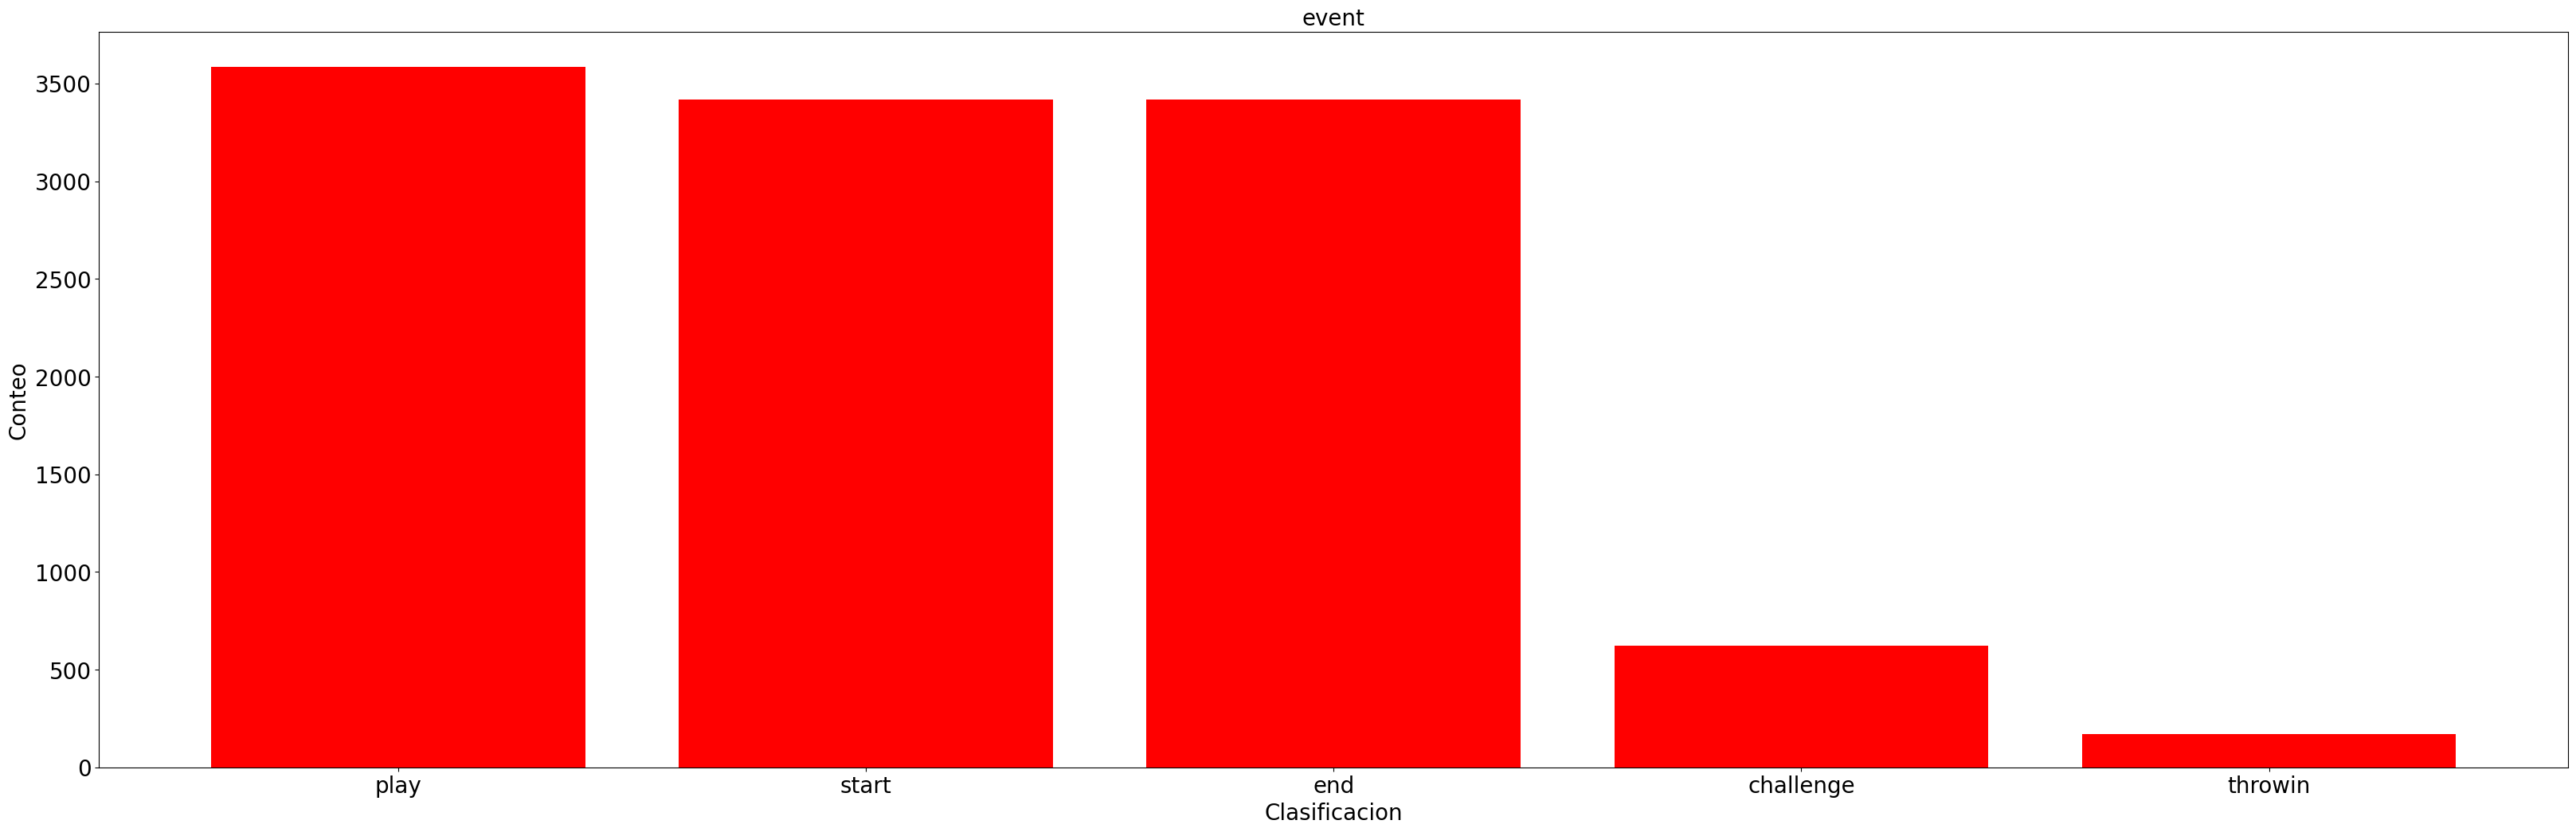

In [15]:
columnas = []

for col in train.columns:
    columnas.append(col)

for columna in columnas:
    count = train[columna].value_counts().sort_values(ascending=False).reset_index()
    count = count.rename(columns={"index": columna, columna: "Count"})
    
    if columna == 'event':  
        plt.figure(figsize=(40,12))
        plt.bar(count[columna], count['Count'], color='r')
        plt.title(columna, size=20)
        plt.xlabel('Clasificacion', size=20)
        plt.ylabel('Conteo', size=20)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()

Luego lo que haremos es calcular cuántos eventos hay en un clip => Clip significa [Inicio ~ Fin] en la anotación train.csv
Los números de inicio y final son los mismos, así que haga que cada lista de valores => pares de (inicio y final) tengan el mismo índice de lista Y luego reste el mismo índice entre dos listas => (resultado-1) ¡será el número medio de eventos en un clip!

2    2622
3     666
4     101
5      21
6       7
7       1
Name: event_number, dtype: int64


Text(0.5, 1.0, 'Distribution of Event Number in One Clip')

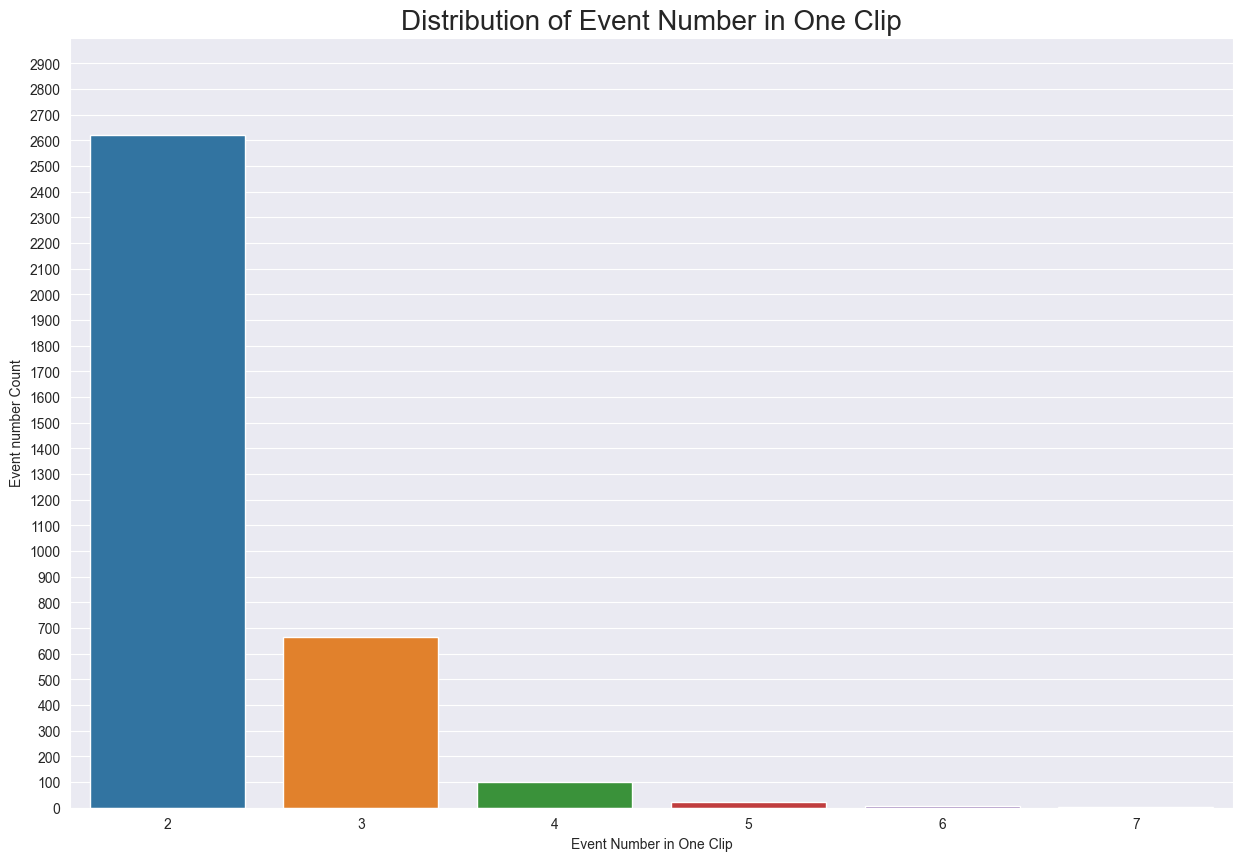

In [16]:

start_index = train.loc[train['event'] == 'start'].index
end_index = train.loc[train['event'] == 'end'].index

event_number = [end_index[i] - start_index[i] for i in range(len(start_index))]
event_number_df = pd.DataFrame(data=event_number, columns=['event_number'])

print(event_number_df['event_number'].value_counts())
sns.set_style(style='darkgrid')
plt.figure(figsize=(15,10))

graph = sns.countplot(data=event_number_df, x='event_number')
graph.set(ylim=(0,3000), yticks=np.arange(0,3000,100))
graph.set(xlabel="Event Number in One Clip", ylabel="Event number Count")
graph.set_title('Distribution of Event Number in One Clip', fontsize=20) 

Cada valor x - 1 => Número de evento en un clip
Ej. x.value 2 significa que en train.csv, hay 2622 clips que tienen "Solo un evento"
Ej) x.value 3 significa que en train.csv, hay 666 clips que tienen "Dos eventos"

Hay 6 tipos de Clip (Intervalo de evento)

Caso 1) Inicio - Evento 1 - Fin (2622)

Caso 2) Inicio - Evento 1 - Evento 2 - Fin (666)

Caso 3) Inicio - Evento 1 - Evento 2 - Evento 3 - Fin (101)

Caso 4) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Fin (21)

Caso 5) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Evento 5 - Fin (7)

Caso 6) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Evento 5 - Evento 6 - Fin (1)

In [17]:
# Paso 1.3 Calcular intervalo en tipo de clip
# Aplicar el mismo método en el paso anterior
start_time = list(train.loc[train['event'] == 'start'].time)
end_time = list(train.loc[train['event'] == 'end'].time)

event_duration = [np.around(end_time[i] - start_time[i],2) for i in range(len(start_time))]
event_duration_df = pd.DataFrame(data=event_duration, columns=['event_duration'])
print(event_duration_df.value_counts())

event_duration
2.50              2622
4.99                15
4.83                13
4.53                11
4.86                10
                  ... 
6.01                 1
6.00                 1
5.92                 1
5.79                 1
13.99                1
Length: 251, dtype: int64
